# Filter Dataset from oyez_gather script
This script takes in input oyez.json as generated by the oyez_gather script.
Here's an already generated dataset:

Minimal JSON compact form (216MB):
https://www.dropbox.com/s/9kyk0dr2gf3ls23/oyez.json?dl=0

Prettified JSON human-readable form (431 MB):
https://www.dropbox.com/s/52a58aac8iujupv/oyez_pretty.json?dl=0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [3]:
# !pip install json
# !pip install pandas
# !pip install numpy
# !pip install nltk
# !pip install bs4
# !pip install re
!pip install contractions

import json
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
import re
from bs4 import BeautifulSoup
import contractions

# Just for visuals
pd.set_option('display.max_colwidth', None)

     |████████████████████████████████| 284 kB 35.0 MB/s 
     |████████████████████████████████| 321 kB 53.3 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85451 sha256=e593258996ce7abfa44d2833329d4be11129386fd1bb31497fffc2fad314da36
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 1. Dataset Preparation

## Load the dataset

In [139]:
base_path = "/content/drive/MyDrive/USC master/CSCI 577 Applied Natural Language Processing/project/coding/"
with open(base_path+'oyez.json', 'r') as f:
    data = json.load(f)

In [140]:
df_scdb = pd.read_csv(base_path+'SCDB_2021_01_caseCentered_Vote.csv', sep=",", encoding='cp1252')

## Filter the dataset to only the columns we need with cases with non-missing values

In [141]:
# Returns true if the given case's judgment has been decided, false otherwise
def is_decided(entry):
    for timeline in entry['timeline']:
        if timeline['event'] == "Decided":
            return True
    return False

# Returns true if the given case has the necessary columns for our analysis, false otherwise
# Currently only considers:
#    1- case's judgment has been decided
#    2- case has a non-empty facts field
#    3- case has a non-empty decisions field
def is_entry_complete(entry):
    try:
        if not is_decided(entry):
            return False
        facts = entry['facts_of_the_case']
        if facts == None or len(str(facts)) == 0:
            return False
        if entry['decisions'] == None or len(entry['decisions']) == 0:
            return False
        return True
    except:
        return False

def fill_votes(entry, row):
  votes = entry['votes']
  if votes == None:
    return
  for idx, vote in enumerate(votes):
    try:
      row['judege_name_{}'.format(idx+1)] = vote['member']['name']
      row['vote_type_{}'.format(idx+1)] = vote['vote']
      row['opinion_type_{}'.format(idx+1)] = vote['opinion_type']

    except KeyError as k:
      if k == 'name':
        row['judege_name_{}'.format(idx+1)] = None
      if k == 'vote':
        row['vote_type_{}'.format(idx+1)] = None
      if k == 'opinion_type':
        row['opinion_type_{}'.format(idx+1)] = None
      

# Returns a dict with only the necessary columns we need from a given case
# Currently the followings columns are considered:
#    1-  case ID (assigned by oyez.org)
#    2-  case name
#    3-  href URL to the oyez.org case
#    4-  docket unique identifier of the case
#    5-  term (read: year)
#    6-  name of the first party
#    7-  name of the second party
#    8-  facts of the case
#    9-  majority vote count
#    10-  minority vote count
#    11- name of the winning party
#    12- the decision type (see below for more detials)
#    13- the disposition type (see below for more details)
def filter_entry(entry):
    row = {}
    row['ID'] = entry['ID']
    row['name'] = entry['name']
    row['href'] = entry['href']
    row['docket'] = entry['docket_number']
    row['term'] = entry['term']
    row['first_party'] = entry['first_party']
    row['second_party'] = entry['second_party']
    row['facts'] = entry['facts_of_the_case']
    
    # As a simplification, only consider the first decision of the case
    # Its rare, but there are cases with multiple decisions.
    # How should we handle those? At the moment, we ignore subsequent decisions
    decision = entry['decisions'][0]
    # fill_votes(decision, row)
    row['majority_vote'] = decision['majority_vote']
    row['minority_vote'] = decision['minority_vote']
    row['winning_party'] = decision['winning_party']
    row['decision_type'] = decision['decision_type']
    row['disposition'] = decision['disposition']
    return row

# Decision Type can be one the following:
#     majority - an opinion in a case that is shared by more than half of the members of a court 
#     per curiam -  said of a judicial opinion presented as that of the entire court rather than that of any one judge
#     plurality opinion - an opinion that received the most votes of any opinion but not enough to be the majority opinion
#     equally divided - ?
#     dismissal - moot - ?
#     dismissal - rule 46 - ?
#     dismissal - other - ?
#     dismissal - improvidently granted - ?
#     memorandum - ?

# Disposition can be a combination of the following:
#     affirmed - lower court judgment was correct
#     reversed - lower court judgment was incorrect
#     remanded - send case back to lower court
#     vacated - lower court judgment has been cancelled or rendered void

In [142]:
filtered_data = []
count = 0
for entry in data:
  if is_entry_complete(entry):
    filtered_data.append(filter_entry(entry))

## Prepare Pandas DataFrame for the Dataset 

In [143]:
df = pd.DataFrame(filtered_data)

# Fill empty/None values with an empty string
# df['winning_party'] = df['winning_party'].fillna('')
# df['disposition'] = df['disposition'].fillna('')

# Remove rows with missing values in the listed columns
# df.dropna(inplace=True, subset=['first_party', 'second_party', 'facts'])

print(f'There are {len(df)} cases.')

There are 3303 cases.


In [144]:
display(df.head(n=1))

,ID,name,href,docket,term,first_party,second_party,facts,majority_vote,minority_vote,winning_party,decision_type,disposition
0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,70-18,1971,Jane Roe,Henry Wade,"<p>In 1970, Jane Roe (a fictional name used in court documents to protect the plaintiff’s identity) filed a lawsuit against Henry Wade, the district attorney of Dallas County, Texas, where she resided, challenging a Texas law making abortion illegal except by a doctor’s orders to save a woman’s life. In her lawsuit, Roe alleged that the state laws were unconstitutionally vague and abridged her right of personal privacy, protected by the First, Fourth, Fifth, Ninth, and Fourteenth Amendments.</p>\n",7,2,Jane Roe,majority opinion,reversed


# 2. Preprocess Dataset

## Statistics before Preprocessing

In [145]:
avg_before_preprocessing = df['facts'].apply(lambda x: len(str(x))).mean()
print(f'Average facts character length (before preprocesesing): {avg_before_preprocessing:.0f}')

Average facts character length (before preprocesesing): 1112


In [146]:
df['facts_len'] = df['facts'].str.len()

## Data Visualization

In [147]:
# Investigate the following:
# - The distribution of the values of each column
# - Missing values of majority and minority votes 
# - add entity type column; a person or organization goverment
# - add issue area

# Some suggestions:
# - Change column names to something better for modeling e.g winning party -> is_first_party_winner

In [102]:
def plot_multi_group(df, groups):
  for group in groups:
    fig, ax = plt.subplots()
    count = df.groupby(group).size()
    percent = df.groupby(group).size()  / 3303 * 100
    ax = percent.plot(kind='barh', figsize=(10,10), xticks = range(0,101,10), fontsize=16, rot=0)

    for i, v in enumerate(zip(percent, count)):
        percent = '{v}%'.format(v = round(v[0],2))
        ax.text(v[0] + 5, i , percent, color='black', fontweight='bold', fontsize=14)
        ax.text(v[0] + 15, i ,str(v[1]), color='blue', fontweight='bold', fontsize=14)
    ax.set_xlabel("Percentage", fontsize=20)
    ax.set_ylabel(group, fontsize=20)
    
# Plot each feature cols with it's data completion
def data_distribution_graph(df, cols):
    for feature in cols:
        fig, ax = plt.subplots()
        percent = df.groupby(feature).size() / df[feature].count() * 100
        count = df.groupby(feature).size()
        
        if feature == 'facts_len':
          count = pd.cut(df['facts_len'], [1,50,500,1000,1500,3000,7000], include_lowest=True)
          percent = df.groupby(count).size() / df[feature].count() * 100
          count = df.groupby(count).size()
          ax = percent.plot(kind='barh', figsize=(10,10), xticks = range(0,101,5), fontsize=12)
        elif feature == 'term':
          ax = percent.plot(kind='barh', figsize=(10,20), xticks = range(0,101,5), fontsize=12)
        else:
          ax = percent.plot(kind='barh', figsize=(10,10), xticks = range(0,101,5), fontsize=12)
         
        # print count and percentage on grapp
        for i, v in enumerate(zip(percent.values, count.values)):
            percent = '{v}%'.format(v = round(v[0],2))
            ax.text(v[0] + 2, i - .25, percent, color='black', fontweight='bold', fontsize=12)
            ax.text(v[0] + 15, i - .25, str(v[1]), color='blue', fontweight='bold', fontsize=12)
            
        ax.set_title('Data Distribution - {feature}'.format(feature= feature), fontsize=20)
        ax.set_xlabel("Percentage", fontsize=20)
        ax.set_ylabel(feature, fontsize=20)

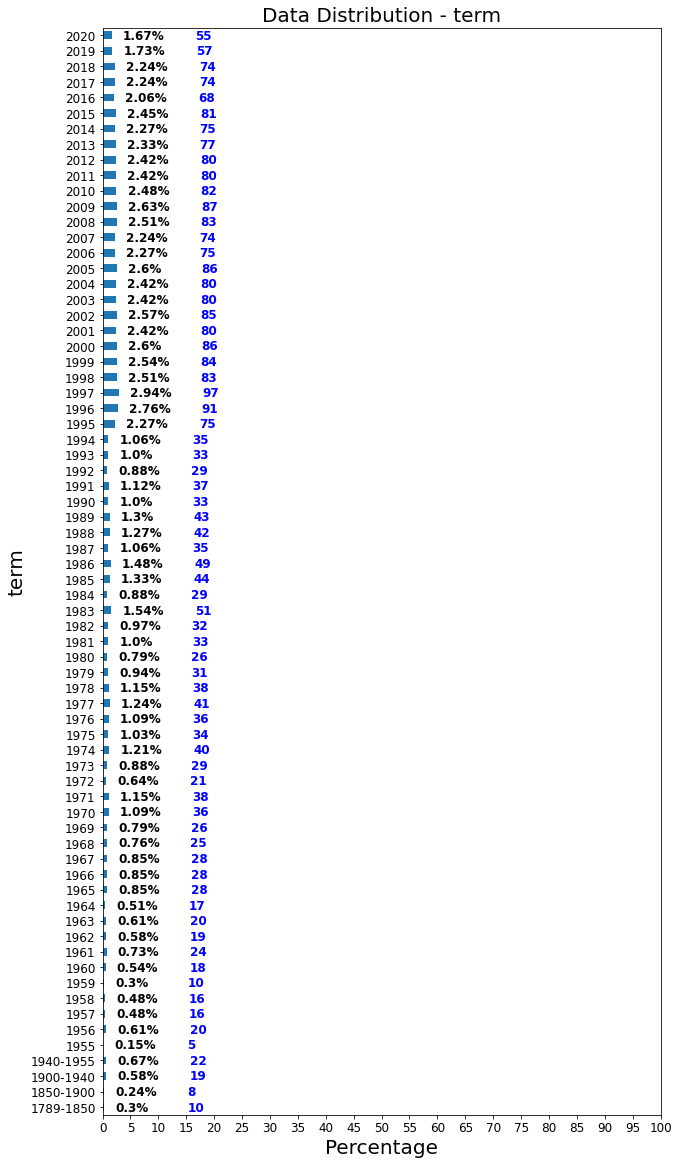

In [334]:
# good
data_distribution_graph(df, ['term'])

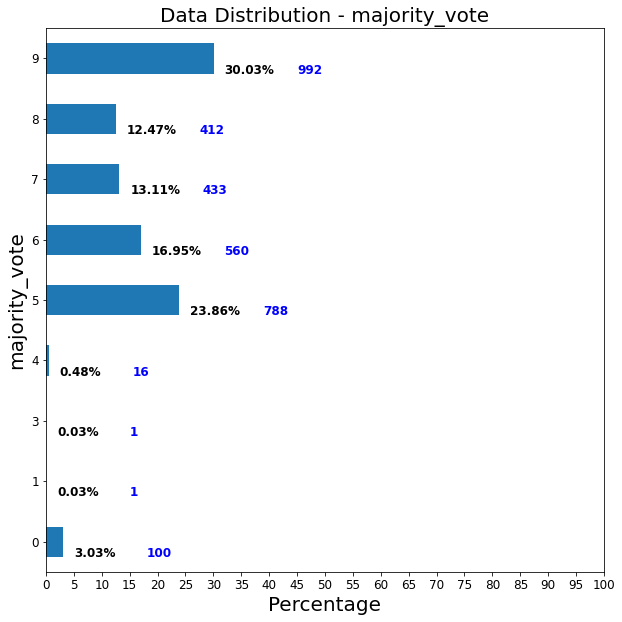

In [191]:
data_distribution_graph(df, ['majority_vote'])

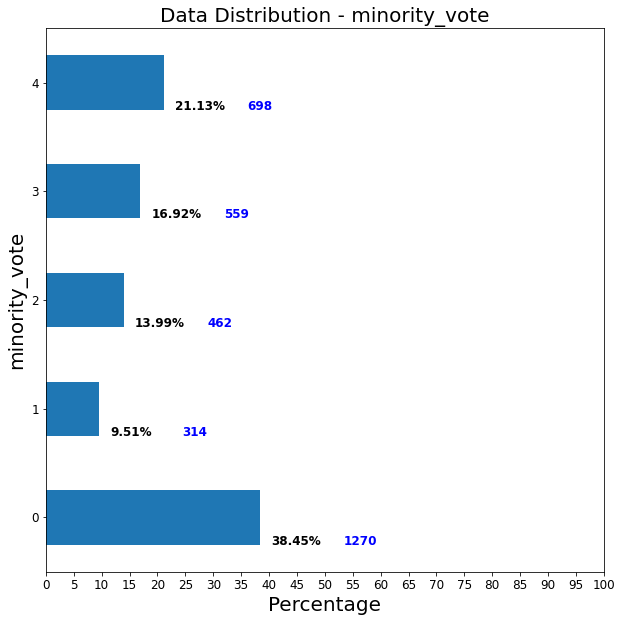

In [118]:
data_distribution_graph(df, ['minority_vote'])

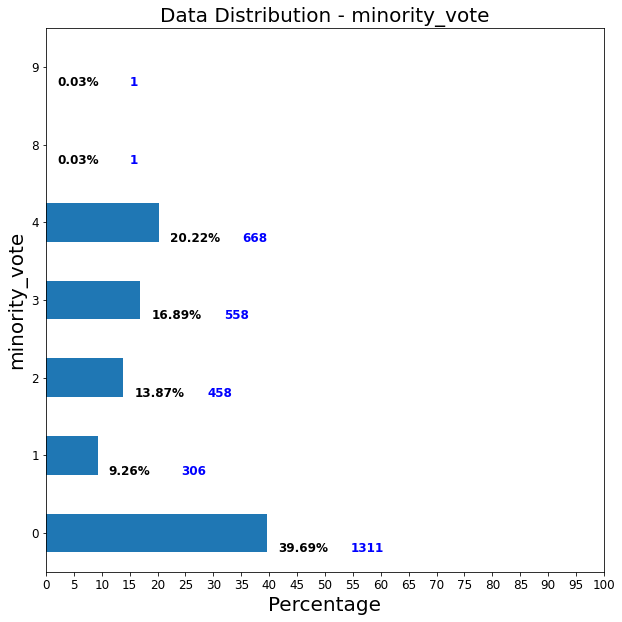

In [192]:
# what happens when minority = 9? is majority = 0?
# what about when minority votes are 8 is the majortiy vote = 1 or maybe 0??
data_distribution_graph(df, ['minority_vote'])

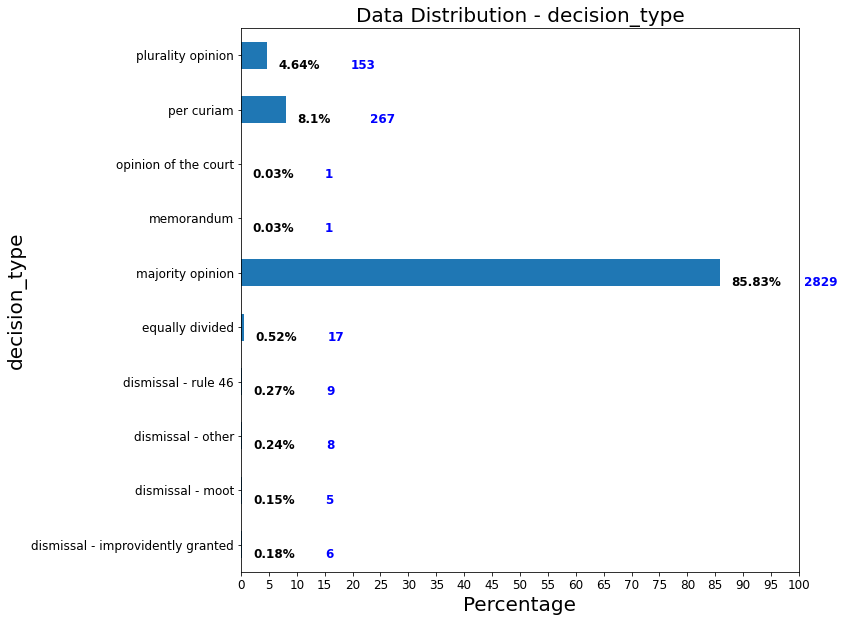

In [103]:
# in equally-divided who is the winning party, check the votes also?
data_distribution_graph(df, ['decision_type'])

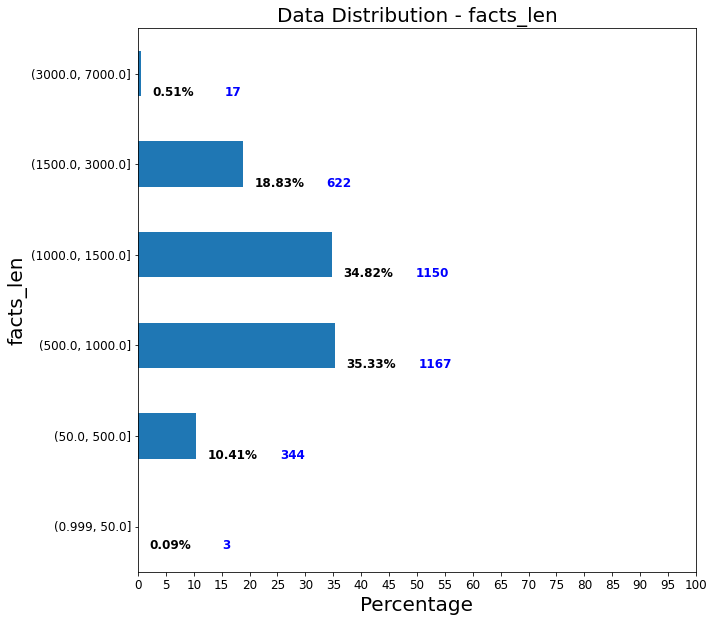

In [109]:
# good
data_distribution_graph(df, ['facts_len'])

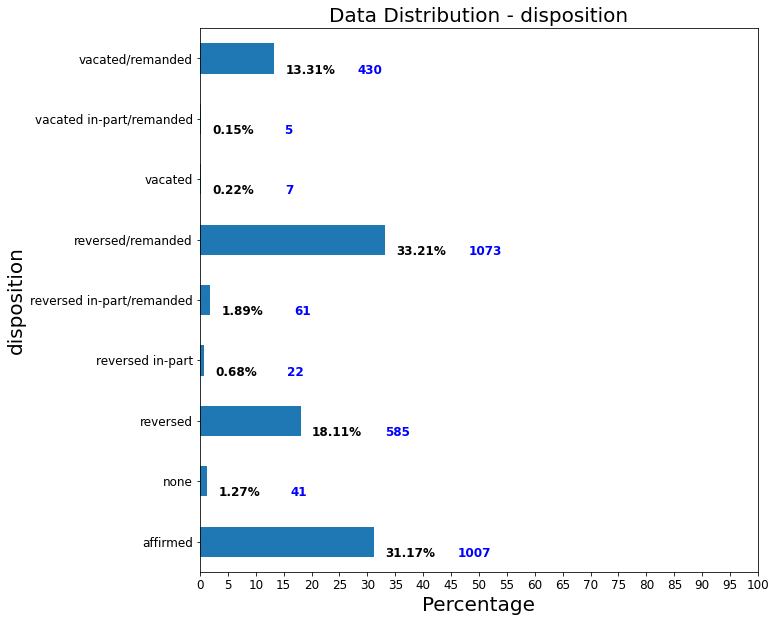

In [110]:
# why do we have none, what are the votes of it, what is the decsion of the case?
data_distribution_graph(df, ['disposition'])

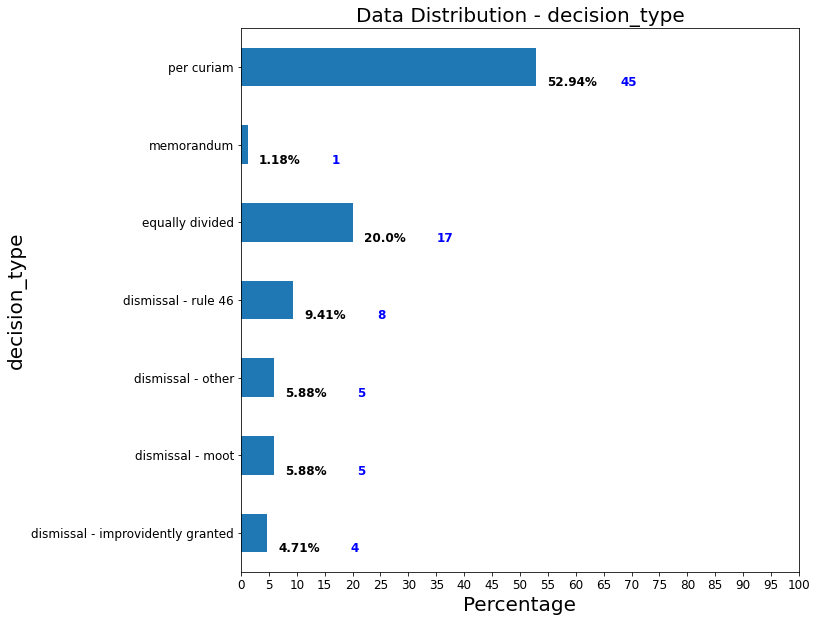

In [106]:
# we can notice that we have 17 cases out of 18 which are equally divided and the votes are = 0 for majority and minority.
# What about the 18th ??? I founded it, it's displayed in the top.
data_distribution_graph(df_zero, ['decision_type'])

In [346]:
# Noticing alot of dismissals though there are votes!
# Some cases have 9 votes for majority though it has been dismissed. How come? Maybe an error??
df.loc[df['disposition'] == 'none'][['name','docket','majority_vote', 'minority_vote', 'decision_type', 'disposition', 'winning_party']]

,name,docket,majority_vote,minority_vote,decision_type,disposition,winning_party
1026,"Caterpillar, Inc. v. International Union, United Automobile, Aerospace and Agricultural Implement Workers of America",96-1925,9,0,per curiam,none,dismissal
1240,Dempsey v. Martin,99-5283,0,1,per curiam,none,Martin
1281,Fiore v. White,98-942,9,0,majority opinion,none,Fiore
1486,Medical Board of California v. Hason,02-479,0,0,dismissal - moot,none,Hason
1721,Bank of China v. NBM L.L.C.,03-1559,0,0,dismissal - rule 46,none,
1779,BCI Coca-Cola Bottling Company of Los Angeles v. Equal Employment Opportunity Commission,06-341,0,0,dismissal - other,none,neither party
1801,"Altadis USA, Inc. v. Sea Star Line, LLC",06-606,0,0,dismissal - rule 46,none,neither party
1840,Ali v. Achim,06-1346,0,0,dismissal - rule 46,none,dismissal
1864,"Klein & Co. Futures, Inc. v. Board of Trade of the City of New York",06-1265,9,0,dismissal - rule 46,none,dismissal
1918,Al-Marri v. Spagone,08-368,0,0,dismissal - moot,none,dismissal


### Defining Entity type for each party

In [301]:
import spacy
nlp = spacy.load("en_core_web_sm")

'Jane Roe'

In [308]:
# add entity or person column for each party:

for idx, value in df.iterrows():
  first = value['first_party']
  second = value['second_party']
  doc = nlp(first)
  for ent in doc.ents:
    df.loc[idx, 'first_party_ner'] = ent.label_
  doc = nlp(second)
  for ent in doc.ents:
    df.loc[idx, 'second_party_ner'] = ent.label_

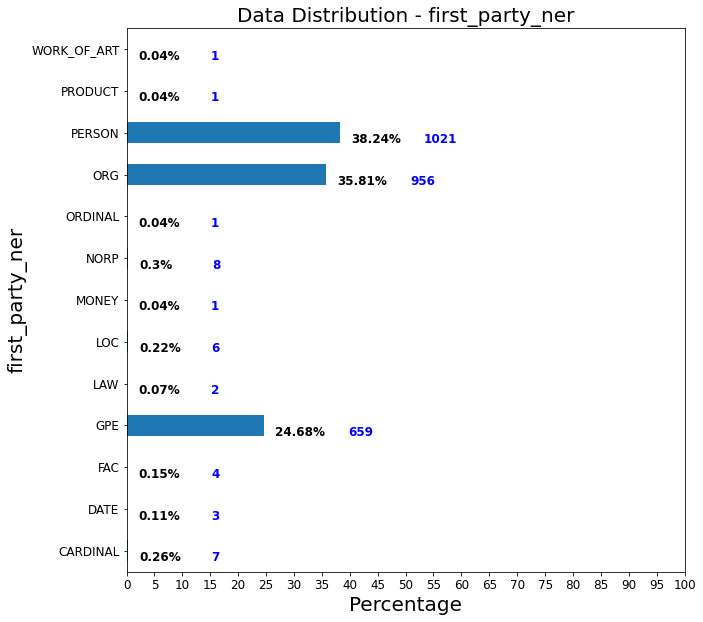

In [309]:
# gave some weired entity names "work_of_art". Try a different way. Look at: http://scdb.wustl.edu/documentation.php?var=petitioner
data_distribution_graph(df, ['first_party_ner'])

In [314]:
df.loc[df['first_party_ner'] == 'WORK_OF_ART']

,ID,name,href,docket,term,first_party,second_party,facts,judege_name_1,vote_type_1,opinion_type_1,judege_name_2,vote_type_2,opinion_type_2,judege_name_3,vote_type_3,opinion_type_3,judege_name_4,vote_type_4,opinion_type_4,judege_name_5,vote_type_5,opinion_type_5,judege_name_6,vote_type_6,opinion_type_6,judege_name_7,vote_type_7,opinion_type_7,judege_name_8,vote_type_8,opinion_type_8,judege_name_9,vote_type_9,opinion_type_9,majority_vote,minority_vote,winning_party,decision_type,disposition,facts_len,zero_condition,first_party_ner,second_party_ner
1549,55152,Jones v. R. R. Donnelley & Sons Company,https://api.oyez.org/cases/2003/02-1205,02-1205,2003,"Edith Jones, et al., on Behalf of Herself and a Class of Others Similarly Situated",R. R. Donnelley & Sons Company,"<p>In November of 1996, Edith Jones and several other African Americans filed a class action lawsuit in federal district court against R.R. Donnelley and Sons, a commercial printing company. They claimed they had suffered racial discrimination in violation of section 1981 of United States Code (U.S.C.), which had no specified statute of limitations. Donnelley and Sons, however, argued that the section was bound by a two-year statute of limitations established by Illinois for all personal injury claims. The suit fell outside that statute of limitations, and the company argued that it should therefore be dismissed.</p>\n<p>Jones, however, argued that a separate section of U.S.C. extended the statute of limitations to four years for any civil suit brought under an act of Congress passed after 1990. Because the 1991 Civil Rights Act had broadened the definition of section 1981, she argued, the four-year statute of limitations should apply to that section and the suit should therefore not be thrown out. Donnelley and Sons countered that the 1991 Civil Rights Act had merely amended the section, not created a new law, and that the four-year statute of limitations therefore did not apply.</p>\n<p>A federal district court sided with Jones. A Seventh Circuit Court of Appeals panel unanimously reversed.</p>\n",William H. Rehnquist,majority,none,John Paul Stevens,majority,majority,Sandra Day O'Connor,majority,none,Antonin Scalia,majority,none,Anthony M. Kennedy,majority,none,David H. Souter,majority,none,Clarence Thomas,majority,none,Ruth Bader Ginsburg,majority,none,Stephen G. Breyer,majority,none,9,0,"Edith Jones, et al., on Behalf of Herself and a Class of Others Similarly Situated",majority opinion,reversed/remanded,1316,0,WORK_OF_ART,PERSON


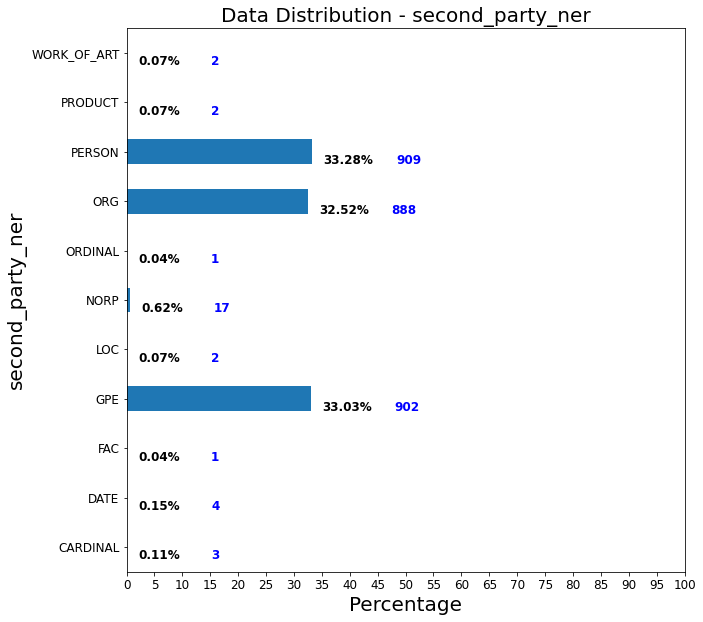

In [310]:
data_distribution_graph(df, ['second_party_ner'])

In [ ]:
# plot_multi_group(df_zero, [['vote_type_1', 'opinion_type_1']])
# plot_multi_group(df_zero, [['vote_type_2', 'opinion_type_2']])
# plot_multi_group(df_zero, [['vote_type_3', 'opinion_type_3']])
# plot_multi_group(df_zero, [['vote_type_4', 'opinion_type_4']])
# plot_multi_group(df_zero, [['vote_type_5', 'opinion_type_5']])
# plot_multi_group(df_zero, [['vote_type_6', 'opinion_type_6']])
# plot_multi_group(df_zero, [['vote_type_7', 'opinion_type_7']])
# plot_multi_group(df_zero, [['vote_type_8', 'opinion_type_8']])
# plot_multi_group(df_zero, [['vote_type_9', 'opinion_type_9']])

## Data Issues

### Ambigous Winner Name

In [97]:
# Boggs vs Boggs who's the winner????
df.loc[df['docket'] == '96-79'][['name','first_party','second_party', 'docket', 'term', 'majority_vote', 'minority_vote', 'winning_party', 'first_party_winner']]

,name,first_party,second_party,docket,term,majority_vote,minority_vote,winning_party,first_party_winner
921,Boggs v. Boggs,Boggs,Boggs,96-79,1996,5,4,Boggs,True


### Votes are swapped

In [285]:
# Another error record, the votes are swaped
df.loc[df['minority_vote'] == 9][['name','docket','majority_vote', 'minority_vote', 'decision_type']]

,name,docket,majority_vote,minority_vote,decision_type
2797,Taylor v. Barkes,14-939,0,9,per curiam


In [286]:
# the correct votes from another source.
df_scdb.loc[df_scdb['docket'] == '14-939'][['caseName','docket','majVotes', 'minVotes', 'decisionType']]

,caseName,docket,majVotes,minVotes,decisionType
13178,TAYLOR v. BARKES,14-939,9,0,2


In [268]:
# Error Record
df.loc[df['docket'] == '78-1577'][['majority_vote', 'minority_vote', 'decision_type']]

,majority_vote,minority_vote,decision_type
290,0,8,equally divided


### Zero Votes

In [271]:
# found it in the equally divided category
df.loc[df['decision_type'] == 'equally divided'][['majority_vote', 'minority_vote']]

,majority_vote,minority_vote
290,0,8
401,0,0
460,0,0
869,0,0
1157,0,0
1207,0,0
1462,0,0
1861,0,0
1901,0,0
2121,0,0


### Major votes with dismisse decision

In [109]:
# why votes 5 and greater have dismissal? check it up
df.groupby(['majority_vote', 'decision_type']).size()

majority_vote  decision_type                    
0              dismissal - improvidently granted      2
               dismissal - moot                       4
               dismissal - other                      4
               dismissal - rule 46                    8
               memorandum                             1
               per curiam                             6
4              equally divided                       17
               majority opinion                      11
               per curiam                             1
               plurality opinion                      5
5              dismissal - other                      1
               majority opinion                     672
               per curiam                            27
               plurality opinion                     92
6              dismissal - improvidently granted      1
               majority opinion                     502
               opinion of the court                   1

### Equally divided votes with affirmed disposition

In [137]:
# why all votes are zero and why dispoisiton affirmed, how come there is a winning party?
df.loc[df['decision_type'] == 'equally divided'][['decision_type','majority_vote', 'minority_vote', 'first_party_winner', 'disposition']]

,decision_type,majority_vote,minority_vote,first_party_winner,disposition


## Data Cleansing

### Create First Party Winner Boolean Column

In [148]:
# create first_party_winner column
double_match = 0
for idx, row in df.iterrows():
  # Na value found
  if row['winning_party'] == None:
    df.loc[idx, 'first_party_winner'] = None
    continue
  # Empty string found
  if not row['winning_party']:
    # print('winning party is empty string')
    df.loc[idx, 'first_party_winner'] = None
    continue
  # First party is none or empty string
  if row['first_party'] == None or not row['first_party']:
    print('first_party is none')
    continue
  # Check if winning party is substring of first party and second (which is a confusion!!)
  match_first_party = row['winning_party'].strip().lower() in row['first_party'].strip().lower()
  match_second_party = row['winning_party'].strip().lower() in row['second_party'].strip().lower()
  if match_first_party and match_second_party:
    double_match += 1
    # print(df.loc[idx][['first_party','second_party', 'docket', 'term', 'majority_vote', 'minority_vote', 'winning_party']])
    # make the first_party_winner none
    df.loc[idx, 'first_party_winner'] = None
    continue

  if match_first_party:
    df.loc[idx, 'first_party_winner'] = True
  else:
    df.loc[idx, 'first_party_winner'] = False

print("Warning: in {} cases, the winning name matched in both parties! Made it None".format(double_match))

In [149]:
# count of Na 
df['first_party_winner'].isna().sum()

894

In [150]:
# Are all records duplicates of itself
def all_duplicates(df):
  selected_cols = df[['docket', 'term', 'majVotes', 'minVotes']]
  flag = selected_cols.duplicated(keep=False)
  return len(selected_cols) == flag.sum()

In [151]:
def find_best_match(case, df):
  df = df.copy()
  # if term is like '1940-1955' return empty
  if len(case['term']) > 4:  
    return pd.DataFrame()
  best_case = df.loc[df['term'] == int(case['term'])] 
  
  # if there are more than one match with same term
  if len(best_case.values) > 1:
    if all_duplicates(best_case):
      return best_case.head(n=1)

    # match with majority and minority votes
    matching_majority = best_case['majVotes'] == int(case['majority_vote'])
    matching_minority = best_case['minVotes'] == int(case['minority_vote']) 
    matching_condition = (matching_majority & matching_minority).astype(int)
    best_case.loc[: ,'matching_condition'] = matching_condition
    df_match = best_case.loc[best_case['matching_condition'] == 1]
    return df_match.head(n=1)
  else:
    return best_case
  return pd.DataFrame() #empty (no match)

def get_matching_case(case, df):
  df = df.copy()
  other_case = df.loc[df['docket'] == case['docket']]
  if other_case.empty:  # if record not found
    return pd.DataFrame()
  if len(other_case.values) > 1:   # if there are more than one match, match with term
    other_case = find_best_match(case, other_case)
  return other_case

### Start analysis by finding all zero votes

In [152]:
# find the majority and minority votes == 0
zero_condition = ((df['majority_vote'] == 0) & (df['minority_vote'] == 0)).astype(int)
df_zero = df.loc[zero_condition == 1]

### Filling the zero votes with scdb.wustl.edu SCOUT database

In [153]:
'''
source: 
Values of Descision Type: http://scdb.wustl.edu/documentation.php?var=decisionType
1	opinion of the court (orally argued)
2	per curiam (no oral argument)
4	decrees
5	equally divided vote
6	per curiam (orally argued)
7	judgment of the Court (orally argued)
8	seriatim
'''
decision_type = {1: 'opinion of the court', 
                 2: 'per curiam', 
                 4: 'decrees', 
                 5:'equally divided', 
                 6: 'per curiam',
                 7: 'judgment of the Court',
                 8: 'seriatim'}

unmatch = []  # if the case was not found in the second source register it
duplicates = [] # if the case has duplicates in the other souce save the row
for idx, zero_case in df_zero.iterrows():
  best_match = get_matching_case(zero_case, df_scdb)
  if best_match.empty:
    unmatch.append(zero_case)
    continue
  # update the majority vote
  df.at[idx, 'majority_vote'] = int(best_match['majVotes'])
  # update the minority vote
  df.at[idx, 'minority_vote'] = int(best_match['minVotes'])
  # update decision type
  df.at[idx, 'decision_type'] = decision_type[best_match['decisionType'].values[0]]
  # update zero condition to false
  df.at[idx, 'zero_condition'] = False
  
if len(unmatch) == 0:
  print("hurray all zeros have been filled!")
else:
  print("still {} missing votes".format(len(unmatch)))

still 25 missing votes


### Fill the empty winning party from scdb

In [154]:
# fill the Na with the winning party form scdb
for idx, row in df.iterrows():
  # first party winner is exists
  if row['first_party_winner']:
    continue
  match_case = get_matching_case(row, df_scdb)
  # didn't find a match
  if match_case.empty:
    continue
  # according to http://scdb.wustl.edu/
  # 0	no favorable disposition for petitioning party apparent => second party is the winner
  # 1	petitioning party received a favorable disposition => first party is the winner

  if match_case['partyWinning'].values[0] == 1:
    df.loc[idx, 'first_party_winner'] = True
  if match_case['partyWinning'].values[0] == 0:
    df.loc[idx, 'first_party_winner'] = False

In [155]:
df['first_party_winner'].isna().sum()

15

### Compare Oyez and SCDB winning parties

In [156]:
# compare the (winning party) between oyez and scdb
different_winner = []
different_votes = []
missed_cases = []
for idx, oyez_case in df.iterrows():
  # empty winning party in oyez then skip
  if oyez_case['first_party_winner'] == None:
    continue
  best_match = get_matching_case(oyez_case, df_scdb)
  # if record not found in scdb skip and append case to not found list
  if best_match.empty:  
    missed_cases.append(oyez_case)
    continue
  mismatch_majority = oyez_case['majority_vote'] != best_match['majVotes'].values[0]
  mismatch_minority = oyez_case['minority_vote'] != best_match['minVotes'].values[0]
  if mismatch_majority or mismatch_minority:
    different_votes.append(oyez_case)
  if oyez_case['first_party_winner'] != best_match['partyWinning'].values[0]:
    different_winner.append(oyez_case)

print("mismatch winners {}".format(len(different_winner)))
print("mismatch votes {}".format(len(different_votes)))
print("missed cases {}".format(len(missed_cases)))

mismatch winners 14
mismatch votes 85
missed cases 122


### Update oyez's different winners and votes with scdb

In [157]:
# update votes and winners
for result in different_votes:
  best_match = get_matching_case(result, df_scdb)
  df.loc[df['ID'] == result['ID'], 'majority_vote'] = int(best_match['majVotes'])
  df.loc[df['ID'] == result['ID'], 'minority_vote'] = int(best_match['minVotes'])

for result in different_winner:
  best_match = get_matching_case(result, df_scdb)
  if best_match['partyWinning'].values[0] == 1:
    df.at[df['ID'] == result['ID'], 'first_party_winner'] = True
  if best_match['partyWinning'].values[0] == 0:
    df.at[df['ID'] == result['ID'], 'first_party_winner'] = False

### Add issue area column

In [158]:
# update issue area
issue_area = {1:	'Criminal Procedure',
2:	'Civil Rights',
3:	'First Amendment',
4:	'Due Process',
5:	'Privacy',
6:	'Attorneys',
7:	'Unions',
8:	'Economic Activity',
9:	'Judicial Power',
10:	'Federalism',
11:	'Interstate Relations',
12:	'Federal Taxation',
13:	'Miscellaneous',
14:	'Private Action'}

for idx, oyez_case in df.iterrows():
  best_match = get_matching_case(oyez_case, df_scdb)
  # if record not found in scdb skip and append case to not found list
  if best_match.empty:
    missed_cases.append(oyez_case)
    continue
  if best_match['issueArea'].values[0] in issue_area:
    df.at[df['ID'] == oyez_case['ID'], 'issue_area'] = issue_area[best_match['issueArea'].values[0]]
  else:
    df.at[df['ID'] == oyez_case['ID'], 'issue_area'] = None


### Display different winners and votes 

In [51]:
for result in different_votes:
  display(df.loc[df['ID'] == result['ID']][['name', 'docket', 'term', 'majority_vote', 'minority_vote', 'winning_party', 'first_party_winner', 'disposition']])
  best_match = get_matching_case(result, df_scdb)
  display(best_match[['caseName', 'docket', 'term', 'majVotes', 'minVotes', 'partyWinning']])
  print()
  print()

In [ ]:
for result in different_winner:
  display(df.loc[df['ID'] == result['ID']][['name', 'docket', 'term', 'majority_vote', 'minority_vote', 'winning_party', 'first_party_winner']])
  best_match = get_matching_case(result, df_scdb)
  display(best_match[['caseName', 'docket', 'term', 'majVotes', 'minVotes', 'partyWinning']])
  print()
  print()

In [111]:
# update disposition and descion type

for idx, oyez_case in df.iterrows():
  best_match = get_matching_case(oyez_case, df_scdb)
  # if record not found in scdb skip and append case to not found list
  if best_match.empty:  
    missed_cases.append(oyez_case)
    continue
  df.at[df['ID'] == oyez_case['ID'], 'decision_type'] = best_match['decisionType'].values[0]
  df.at[df['ID'] == oyez_case['ID'], 'dispoisition'] = best_match['caseDisposition'].values[0]

In [135]:
df.isna().sum()

ID                       0
name                     0
href                     0
docket                   0
term                     0
first_party              0
second_party             0
facts                    0
majority_vote            0
minority_vote            0
winning_party          884
decision_type            3
disposition             72
facts_len                0
first_party_winner      15
zero_condition        3242
dispoisition           135
issue_area             142
dtype: int64

## Save Dataset

In [161]:
good_cols = ['ID', 'name', 'href', 'docket', 'term',	'first_party'	,'second_party', 'facts','facts_len', 'majority_vote',	'minority_vote','first_party_winner',	'decision_type',	'disposition',	'issue_area']
good_df = df[good_cols]
good_df.to_csv(base_path + 'clean_cases.csv')

## Statistics after Preprocessing

In [ ]:
avg_after_preprocessing = df['facts'].apply(lambda x: len(str(x))).mean()
print(f'Average facts character length (after preprocesesing): {avg_after_preprocessing:.0f}')

In [ ]:
display(df.head(n=3))